In [4]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
import sys
import time
from IPython import display
from mpl_toolkits import mplot3d
from sklearn import datasets

# 8 Optimization - Neural Networks - More networks

## Learning in a better way - gradient descent!

Let's return to our very simple model of neurons, for which we said that we can write their output as the activation function applied to the linearly weighted input:
$$
\vec{y}=f(\vec{w}^{\top}\vec{x})
$$


Now, we need to find a way to **learn** the weights $\vec{w}$ somehow. 

In the previous perceptron examples, we did this by updating the weights with the class-weighted sample - $\vec{w}=\vec{w}+y_k\vec{x}_k$, but how would we do this in a general case?

Let's try to do **gradient descent**!!

Let's again go to our standard way of doing things and minimize the least squares error of some target values $\vec{t}$ versus the prediction. So, let's write our loss function:

$$
l(\vec{w})=\frac{1}{2} \sum \|\vec{y}(\vec{w})-\vec{t}\|^2
$$

Now we remember that the output is some kind of function of the weighted sum of all inputs $\vec{x}$, i.e., $\vec{y}=f(\vec{w}^{\top}\vec{x})$, so we can take the derivative:

$$
\frac{\partial l(\vec{w})}{\partial \vec{w}}= \left ( f(\vec{w}^{\top}\vec{x})-\vec{y}\right ) \frac{\partial f(\vec{w}^{\top}\vec{x})}{\partial \vec{w}}
$$

$$
=\left ( f(\vec{w}^{\top}\vec{x})-\vec{y}\right )\vec{x} \frac{\partial f(\vec{w}^{\top}\vec{x})}{\partial(\vec{w}^{\top}\vec{x})}
$$

So, once we've decided on an activation function, we can determine this derivative and then try to optimize the whole loss function via gradient descent.

#### Linear activation function: $f=x$

If the activation function $f$ is simply the identity function $f(\vec{x}) = \vec{x}$, then this derivative becomes very simple, as its derivative is $\vec{1}$:

$$
\frac{\partial l(\vec{w})}{\partial \vec{w}}=\left ( \vec{w}^{\top}\vec{x}-\vec{y}\right )\vec{x} 
$$

So, now our update for the gradient can be calculated, and it will be:

$$
-\lambda\frac{\partial l(\vec{w})}{\partial \vec{w}}=-\lambda \left ( \vec{w}^{\top}\vec{x}-\vec{y}\right )\vec{x} 
$$

#### Logistic activation function: $f=\frac{1}{1+e^{-x}}$

If the activation function $f$ is the logistic function $f=\frac{1}{1+e^{-\vec{w}^{\top}\vec{x}}}$, its derivative is related to the function itself, and so the whole term becomes:

$$
\frac{\partial l(\vec{w})}{\partial \vec{w}}=\left ( f(\vec{w}^{\top}\vec{x})-\vec{y}\right )\vec{x}f(\vec{w}^{\top}\vec{x})(1-f(\vec{w}^{\top}\vec{x})) 
$$

#### ReLU activation function: $f=\text{ReLU}=\max(0,x)$

This function is not differentiable at $x=0$, so we will arbitrarily say that

$$
f'(x)=\left \{ \begin{array}{cc}1&: x>0\\0&:x\leq 0 \end{array} \right .
$$

where, again, we made the choice to make the derivative 0 at $x=0$ in order to "solve" the discontinuity issue.

#### Note
Note also that the internal process of weighting the inputs $\vec{x}$ with the weights of the neurons $\vec{w}$ will include the bias implicitly with a 1 added to the first dimension of the inputs, such that 

$$
\vec{w}^{\top}\vec{x}=w_0+w_1x_1+w_2x_2+...+w_nx_n
$$

for $n$ neurons.

## Multi-layer networks: Backpropagation
Now, this approach is all fine, if we only have one layer of neurons - but what about multiple, connected neurons that live in different layers like the connections we see in the brain??

Formally, we will start with a fully-connected neural network, in which each neuron is connected to all other neurons in the next down-stream layer.

We have an input layer consisting of the vectorized inputs, and then several so-called "hidden" layers, containing neurons with an activation function $f$ that receive linearly-weighted inputs from their previous 

![fully_connected](004_NN_FCN.png)

The error in the output of an arbitrary neuron in a neural network will depend on all previous weights, so if we want to do gradient descent, we need to somehow know how to derive this.

Again, we assume that each neuron $j$ will provide an output $y_j$, which is defined as the weighted sum of inputs pushed through the activation function:

$$
y_j = f(\vec{w}\vec{x})=f(\sum w_{kj}x_k)
$$

So, the derivative of the total error with respect to any weight $w_{ij}$ is done using the full sets of dependents:

$$
\frac{\partial l}{\partial w_{ij}}=\frac{\partial l}{\partial y_{j}}\frac{\partial y_j}{\partial w_{ij}}=\frac{\partial l}{\partial y_{j}}\frac{\partial y_j}{\partial (\sum w_{kj}y_k)}\frac{\partial (\sum w_{kj}y_k)}{\partial w_{ij}}
$$

Let's look at the three terms. Let's start with the second term, which is the derivative of the error function. Let's assume it's the logistic function, which has the neat and simple derivative from above

$$
\frac{\partial y_j}{\partial (\sum w_{kj}y_k)}=f(\sum w_{kj}y_k)(1-f(\sum w_{kj}y_k))
$$

For the third term we observe that in the sum only one term contains the actual derivative weight $w_{ij}$, so that becomes:

$$
\frac{\partial (\sum w_{kj}y_k)}{\partial w_{ij}}=y_i
$$

Now, for the first term, we distinguish two cases: if the neuron is in the final layer, then $y_j=y_{end}$, which means:

$$
\frac{\partial l}{\partial y_{j}}=\frac{\partial l}{\partial y_{end}}= \frac{\partial l}{\partial y_{j}} \cdot f(\sum w_{kj}y_k)(1-f(\sum w_{kj}y_k))
$$

For "inner" neurons $j$ in other layers, however, this term needs to be evaluated with respect to earlier layers as well, since the error term depends on the outputs of all neurons connected to the present neuron. Let's put all these $a$ connected neurons into one set $N=\{n_{1j},\dots,n_{aj}\}$

$$
\frac{\partial l(y_{j})}{\partial y_{j}}=
\sum_{n\in N}\left ( \frac{\partial l}{\partial (\sum w_{nj}y_n)}\frac{\partial (\sum w_{nj}y_n)}{\partial y_j} \right )=\sum_{n\in N}\left ( \frac{\partial l}{\partial y_n}\frac{\partial y_n}{\partial (\sum w_{nj}y_n)}\frac{\partial (\sum w_{nj}y_n)}{\partial y_j} \right )=\sum_{n\in N}\left ( \frac{\partial l}{\partial y_n}\frac{\partial y_n}{\partial (\sum w_{nj}y_n)}w_{jn} \right )
$$

This means that we can calculate the derivative, once we know all of the derivatives with respect to the downstream connected neurons. This is why this is called backpropagation, since in order to run the algorithm, you start from the output layer, and then proceed backwards through the network!

In total, we get for a logistic activation function:

$$
\frac{\partial l}{\partial w_{ij}}=y_i\alpha_j
$$

with 
$$
\alpha_j:=\frac{\partial y_j}{\partial (\sum w_{kj}y_k)}\frac{\partial (\sum w_{kj}y_k)}{\partial w_{ij}}=\left \{ \begin{array}{ll} \frac{\partial l}{\partial y_{j}} \cdot f(\sum w_{kj}y_k)(1-f(\sum w_{kj}y_k)) \cdot f(\sum w_{kj}y_k)(1-f(\sum w_{kj}y_k))&: \text{if }j\text{ is an output layer neuron}\\ \sum_{n\in N}\left ( \frac{\partial l}{\partial y_n}\frac{\partial y_n}{\partial (\sum w_{nj}y_n)}w_{jn} \right )\cdot f(\sum w_{kj}y_k)(1-f(\sum w_{kj}y_k))&: \text{if }j\text{ is an inner/hidden layer neuron} \end{array}\right .
$$

### Example implementation

Here's an example implementation that learns a simple one hidden-layer network with a few neurons in order to approximate a $f(x,y)=x^2+y^2+1$.

We generate 400 input/output value pairs and then try to learn the whole thing using our update rules from above.

Let's first define activation functions and their derivatives.

In [5]:
def relu(X):
    return np.maximum(X,0)

def relu_derivative(X):
    return 1. * (X > 0)  # 먼저 array의 element들을 죽 돌아서 X>0인지 살펴보고 True, False로 나오고, 걔네들에 1.은 1을 1.0으로 하는 float 버전을 곱해주어 1.0, 0.0으로 만들어준다.

def tanh(X):
    return np.tanh(X)

def tanh_derivative(X):
    return (1. -tanh(X)**2)  # 1 - tanh(X)^2


def logistic(X):
    return (1. / (1 + np.exp(-X)))

def logistic_derivative(X):
    return (logistic(X)*(1.-logistic(X)))

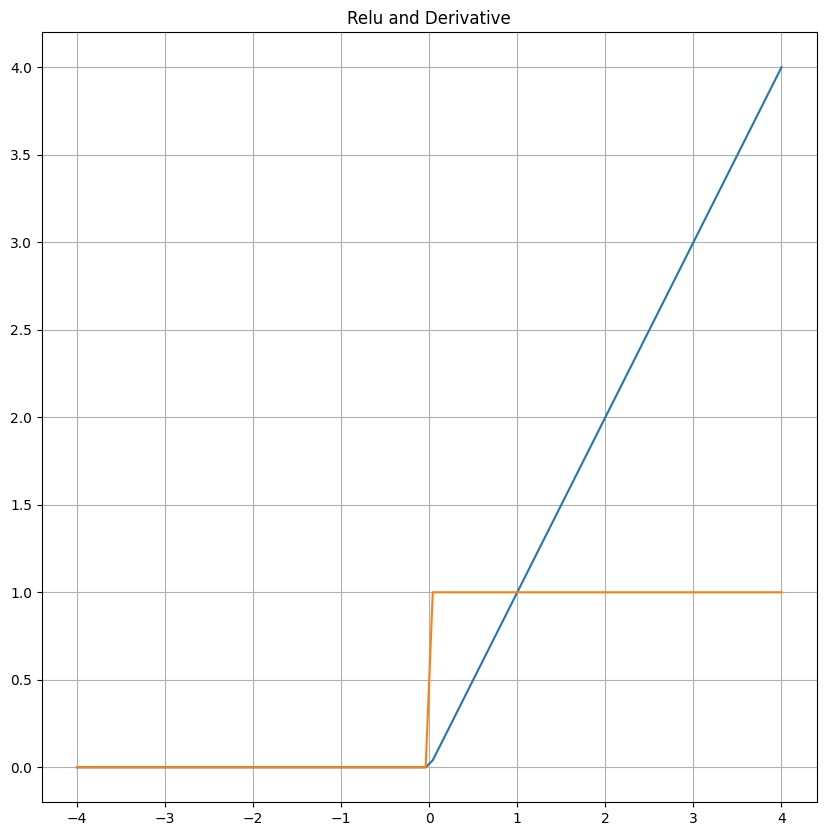

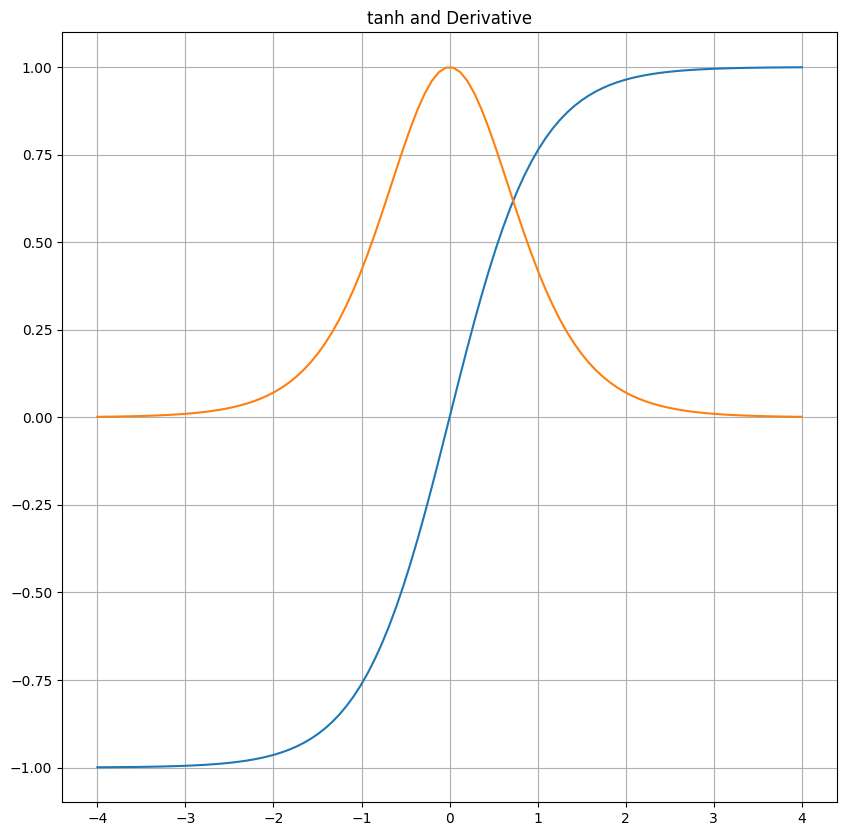

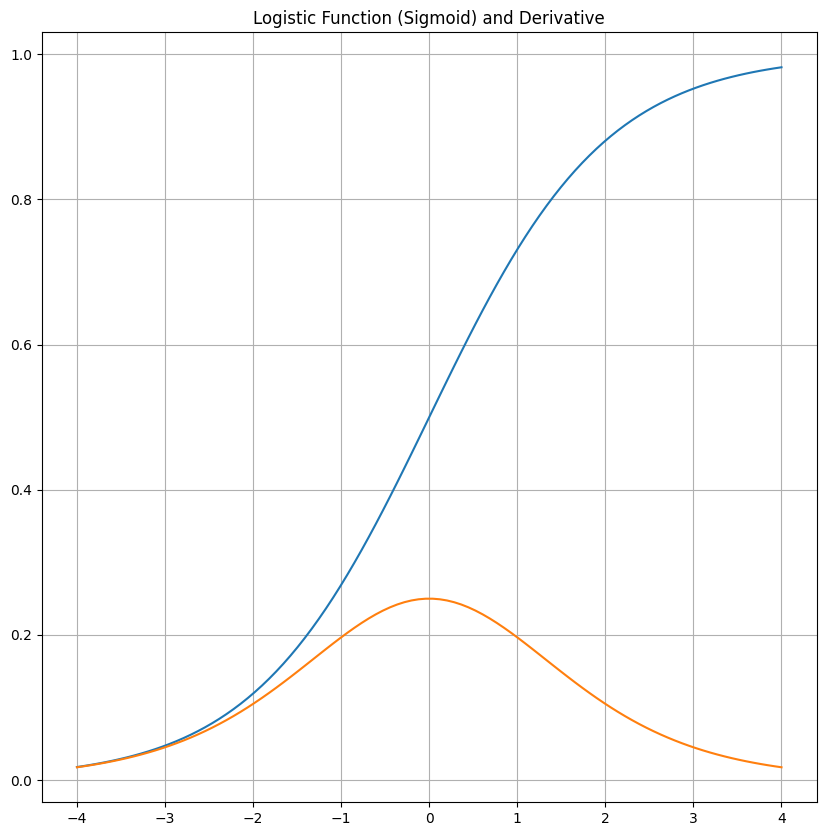

In [6]:
%matplotlib inline
xs=np.linspace(-4,4,100)
plt.figure(figsize=(10,10))
plt.plot(xs,relu(xs))
plt.plot(xs,relu_derivative(xs))
plt.grid()
plt.title('Relu and Derivative')

plt.figure(figsize=(10,10))
plt.plot(xs,tanh(xs))
plt.plot(xs,tanh_derivative(xs))
plt.grid()
plt.title('tanh and Derivative')

plt.figure(figsize=(10,10))
plt.plot(xs,logistic(xs))
plt.plot(xs,logistic_derivative(xs))
plt.grid()
plt.title('Logistic Function (Sigmoid) and Derivative')
plt.show()

Now, let's create a two-layer neural network that features two input dimensions, one fully-connected hidden layer, and a fully-connected output layer.

The hidden layer will receive an activation function, whereas the output layer will simply be a linear layer, as we are trying to solve a regression problem (again, why do we not give this layer an activation function like tanh???). #Because the derivative contains negative values?

In [7]:
# create a two-layer neural network
def create_model(X,hidden_nodes,output_dim=2):
    # this will hold a dictionary of layers
    model = {}
    # input dimensionality
    input_dim = X.shape[1]
    # first set of weights from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes) / np.sqrt(input_dim) #뒤에 이게 있는 이유는 input_dim이 커짐에 따라 vanishing Grad, Exploding Grad인데 이를 방지하기 위해 input 차원으로 나눠준다.
    # input으로 들어간 애들이 hidden layer에서 한 뉴런으로 합쳐지기 때문에 input 차원이 높을 수록 더해지는 값이 많으므로 커질 수 밖에 없다.
    # set of biases
    model['b1'] = np.zeros((1, hidden_nodes)) #이 bias는 처음에는 0이지만 나중에 훈련을 통해 조절된다. For many activation functions, such as ReLU, 
    #starting with a bias of zero means the output is non-negative if the combined input weight product is non-negative. 
    #This can lead to more stable gradients in the initial phases of training, as adjustments to biases become purely driven by the error signals received during backpropagation, 
    #rather than initial bias settings.
    
    # second set of weights from hidden layer 1 to output
    model['W2'] = np.random.randn(hidden_nodes, output_dim) / np.sqrt(hidden_nodes)
    # set of biases
    model['b2'] = np.zeros((1, output_dim))
    return model

# defines the forward pass given a model and data
def feed_forward(model, x):
    # get weights and biases
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # first layer
    z1 = x.dot(W1) + b1 #x에 바로 weight를 dot 시켜야하니까 이렇게 코드를 짠다
    
    # activation function
    #a1 = ...
    #a1 = ...
    a1 = relu(z1)
    
    # second layer
    z2 = a1.dot(W2) + b2
    
    # no activation function as this is simply a linear layer!!
    out = z2
    return z1, a1, z2, out

# define the regression loss
def calculate_loss(model,X,y,reg_lambda):
    num_examples = X.shape[0]
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # what are the current predictions
    z1, a1, z2, out = feed_forward(model, X)
    
    # calculate L2 loss
    loss = 0.5*np.sum((out-y)**2)
    
    # add regulatization term to loss
    loss += reg_lambda/2 * (np.sum(np.square(W1) + np.sum(np.square(W2))))
    
    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def backprop(X,y,model,z1,a1,z2,output,reg_lambda):
    
    # derivative of loss function
    delta3 = (output - y) / X.shape[0]  #\frac{\partial L}{\partial z_2} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z_2}
    #dL/dz2 = dL/dy * dy/dz2 인데 dy/dz2가 output이 z2 그대로 나가기 때문에 1이 된다. 그래서 dL/dz2가 델타3이 되는거고 이게 output - y 그대로 들어가는 것이다.

    # multiply this by activation outputs of hidden layer
    dW2 = (a1.T).dot(delta3) #dW2가 dL/dW2를 구해서 이거를 lr이랑 곱해서 W2에 더해주는게 포인트. dL/dW2 = dL/dz2 * dz2/dW2 이렇게 되고, dL/dz2는 위에서 델타3이었으니 dz2/dW2만 하면 되고, 이거는 
    # z2 = a1*W2 + b2이기 때문에 a1만 남는다. 차원 맞춰주기 위해서 transpose 해주면 dW2가 된다. 
    # and over all neurons
    db2 = np.sum(delta3, axis=0, keepdims=True)
    
    # derivative of activation function
    #delta2 = ... #if logistic
    #delta2 = ... #if tanh
    delta2 = delta3.dot(model['W2'].T) * relu_derivative(a1) #if ReLU
    #여기서 delta2는 dL/da1을 말하는 부분이다. a1 = X*W1 + b1이기 때문에 이걸 알아야 앞에 있는 dL/dW1을 chain rule로 구해줄 수 있다.
    
    # multiply by input data
    dW1 = np.dot(X.T, delta2)
    # and sum over all neurons
    db1 = np.sum(delta2, axis=0)
    #This collective gradient reflects the overall impact of the biases on the loss across the entire batch. 
    #By understanding this cumulative effect, the biases can be adjusted effectively to minimize the overall loss
    
    # add regularization terms on the two weights
    dW2 += reg_lambda * model['W2']
    dW1 += reg_lambda * model['W1']
    
    return dW1, dW2, db1, db2

# simple training loop
def train(model, X, y, num_passes=100000, reg_lambda = 0.1, learning_rate = 0.001):
    # whether to do stochastic gradient descent
    sgd = True
    
    # variable that checks whether we break iteration
    done = False
    
    # keeping track of losses
    previous_loss = float('inf')
    losses = []

    # iteration counter
    i = 0
    while done == False:
        if sgd:
            # choose a random set of points
            randinds = np.random.choice(np.arange(len(y)),30,False)
            # get predictions
            z1,a1,z2,output = feed_forward(model, X[randinds,:])
            # feed this into backprop
            dW1, dW2, db1, db2 = backprop(X[randinds,:],y[randinds],model,z1,a1,z2,output,reg_lambda)
        else:
            # get predictions
            z1,a1,z2,output = feed_forward(model, X)
            # feed this into backprop
            dW1, dW2, db1, db2 = backprop(X,y,model,z1,a1,z2,output,reg_lambda)
            
        # given the results of backprop, update both weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        
        # do some book-keeping every once in a while
        if i % 1000 == 0:
            loss = calculate_loss(model, X, y, reg_lambda)
            losses.append(loss)
            print("Loss after iteration {}: {}".format(i, loss))
            # very crude method to break optimization
            if np.abs((previous_loss-loss)/previous_loss) < 0.001:
                done = True
            previous_loss = loss
        i += 1
        if i>=num_passes:
            done = True
    return model, losses

Let's now create the data and train the model

In [8]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1

# training set size
num_examples = len(X) 
# input layer dimensionality
nn_input_dim = 2 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 0.001
# regularization strength
reg_lambda = 0.01 

# create the model
model = create_model(X,10,1)

# train it
model, losses = train(model,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate)

# determine predictions of the trained model
output = feed_forward(model, X)

Loss after iteration 0: 1589.89720409949
Loss after iteration 1000: 22.725374501256567
Loss after iteration 2000: 9.35918588618716
Loss after iteration 3000: 6.866150113298329
Loss after iteration 4000: 4.891831241800738
Loss after iteration 5000: 3.894868047653422
Loss after iteration 6000: 3.6953380870922916


/var/folders/j2/bs26lyw51kq5vvb8gr82czpm0000gn/T/ipykernel_54209/2219856350.py:130: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs((previous_loss-loss)/previous_loss) < 0.001:


Loss after iteration 7000: 3.209127343205792
Loss after iteration 8000: 3.8273313602964634
Loss after iteration 9000: 2.935866989090646
Loss after iteration 10000: 2.7797257591366384
Loss after iteration 11000: 2.8670012703868486
Loss after iteration 12000: 2.688904834611401
Loss after iteration 13000: 2.7252566707435415
Loss after iteration 14000: 2.5811101544575035
Loss after iteration 15000: 2.4080009813522536
Loss after iteration 16000: 2.4624011750025345
Loss after iteration 17000: 2.4524329414265895
Loss after iteration 18000: 2.841084901886509
Loss after iteration 19000: 2.412263460598157
Loss after iteration 20000: 2.4187157607900973
Loss after iteration 21000: 2.363523556617667
Loss after iteration 22000: 2.450101576114757
Loss after iteration 23000: 2.359639528714336
Loss after iteration 24000: 2.3359916131381686
Loss after iteration 25000: 2.627671136255746
Loss after iteration 26000: 2.507107917589756
Loss after iteration 27000: 2.44067605150477
Loss after iteration 28000: 

What does the loss curve look like?

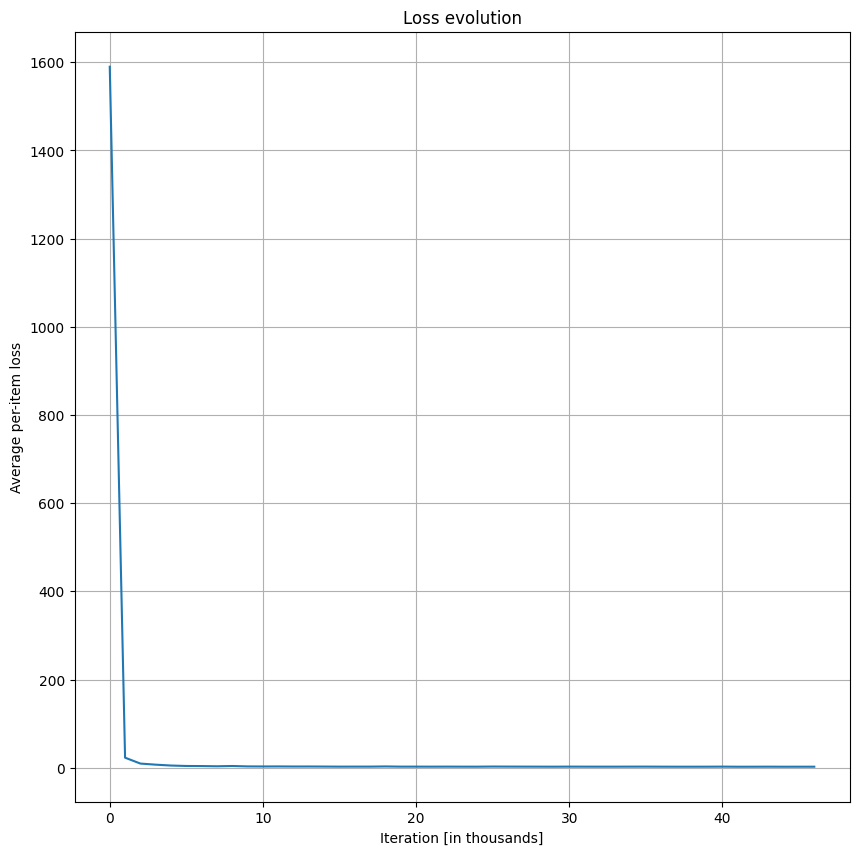

In [9]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

Now let's plot the source data and - in a separate plot - the predictions.

Remember that our data is a 2D surface, so we need to generate the mesh for plotting, etc.

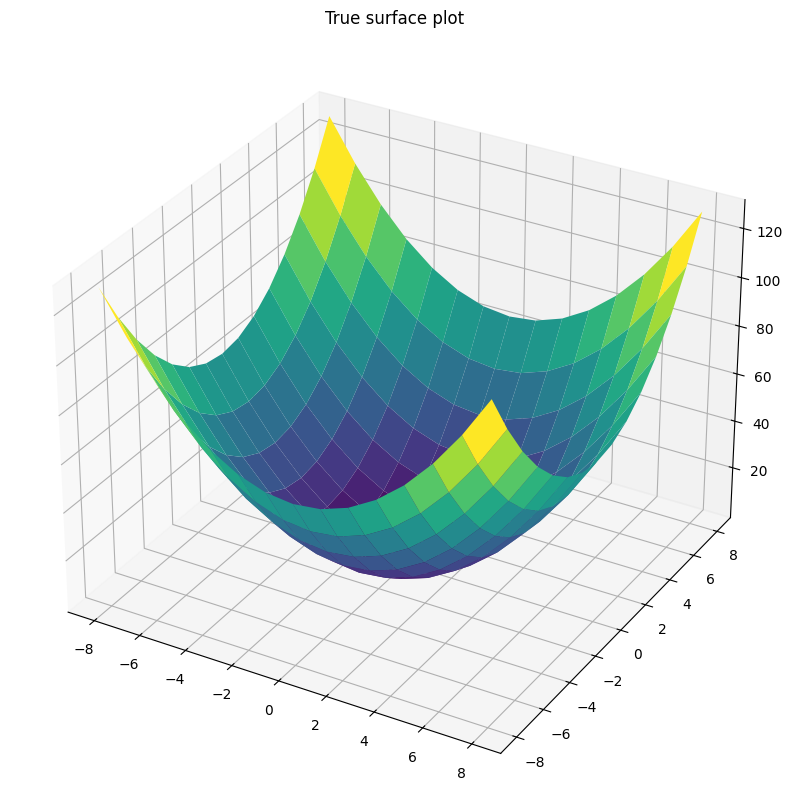

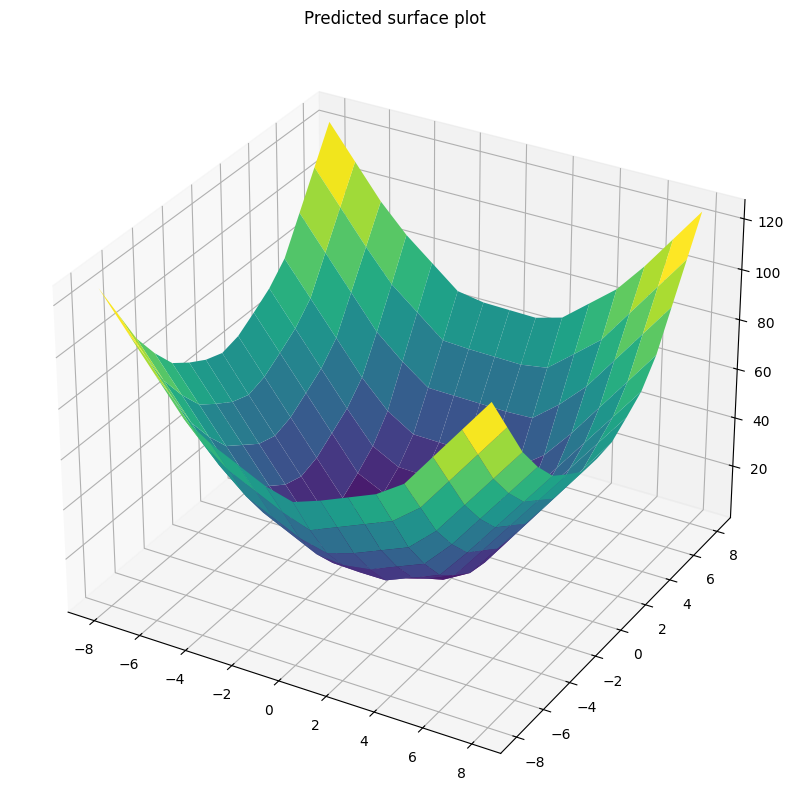

In [14]:
# plot data
[xsm,ysm]=np.meshgrid(xs,ys)
target = np.zeros((numDataOne,numDataOne))
for i,x in enumerate(xs):
    for j,y in enumerate(ys):
        target[i,j]=x**2+y**2+1

%matplotlib inline
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xsm, ysm, target,cmap='viridis', edgecolor='none')
ax.set_title('True surface plot')
plt.show()

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xsm, ysm, np.reshape(output[3],(numDataOne,numDataOne)),cmap='viridis', edgecolor='none')
ax.set_title('Predicted surface plot')
plt.show()

## Classification problems

Let us return to a classification problem again - we saw that in the previous section, we had used the standard L2 loss, minimizing the point-wise squared errors between target and prediction:

$$
L = \sum ||\vec{t}-\vec{y}||^2
$$

This is - despite its problems - with respect to sensitivity to outliers, a standard loss for a regression problem often called the mean squared error (MSE) loss.

So, would this loss also work for classification???

If you think about the problem of classification, then this loss per se is fine, as we could, for example, require the output of the final layer to be the "index" of the class in a multi-class classification problem.

However, there is another way to phrase the classification problem that represents an easier conceptualization and visualization.

Again, we have $C$ classes to classify. Instead of having one output neuron, what we do, is to change the output layer such that it has $C$ output predictions (neurons).

Here, each neuron $y_i$, $i=1...C$ in the final layer will express its support for the class $i$. Finding the "correct" class for the multi-class problem then simply becomes a problem of choosing $\text{argmax}(y_i)$.

So, how do we make such a loss?

### Softmax

First of all, choosing the maximum of a value is an operation that is not easily differentiable. As we have discussed before, one easy way to avoid this is to approximate the maximum operation with a "softer" version, the so-called softmax, which can be interpreted as a probability if properly normalized like so:

$$
\text{softmax}(\vec{z})_i = p_i = \frac{e^{z_i}}{\sum_{j=1}^N e^{z_j}} := \frac{e^{z_i}}{\Sigma N}
$$


where $\vec{z}_i$ indexes the $i$-th output of the neural network.

In order to do backpropagation, we need the derivative of this softmax operation.

$$
\frac{\partial p_i}{\partial z_k}
$$

We know have two cases for this derivative depending on the index $k$: $k=i$ and $k\neq i$. 

#### Case 1: $k=i$

$$
\frac{\partial p_i}{\partial z_i}=\frac{\partial}{\partial z_i}\frac{e^{z_i}}{\Sigma N}=\frac{\Sigma N \frac{\partial e^{z_i}}{\partial z_i}-e^{z_i}\cdot\frac{\partial \Sigma N}{\partial z_i}}{(\Sigma N)^2}
$$

the two missing partial derivatives are calculated as follows:

$$
\frac{\partial \Sigma N}{\partial z_i} = \frac{\partial \sum_{i \neq j} e^{z_j}}{\partial z_i}+\frac{\partial e^{z_i}}{\partial z_i} = e^{z_i}
$$

$$
\frac{\partial e^{z_i}}{\partial z_i} = e^{z_i}
$$

with that, we have:

$$
\frac{\partial p_i}{\partial z_i}=\frac{\Sigma N\cdot e^{z_i} - e^{z_i}\cdot e^{z_i}}{(\Sigma N)^2}=\frac{e^{z_i}}{\Sigma N}\left ( 1 - \frac{e^{z_i}}{\Sigma N}\right ) = p_i(1-p_i)
$$

$$
\rightarrow\frac{\partial p_i}{\partial z_i}= p_i(1-p_i)
$$

#### Case 1: $k\neq i$

$$
\frac{\partial p_i}{\partial z_j}=\frac{\partial}{\partial z_j}\frac{e^{z_i}}{\Sigma N}=\frac{\Sigma N \frac{\partial e^{z_i}}{\partial z_j}-e^{z_i}\cdot\frac{\partial \Sigma N}{\partial z_j}}{(\Sigma N)^2}
$$

and now the first term in the nominator is 0:

$$
= 0 - \frac{e^{z_i}\cdot e^{z_j}}{(\Sigma N)^2} = 0 - \frac{e^{z_i}}{\Sigma N}\cdot \frac{e^{z_j}}{\Sigma N}= -p_i p_j
$$

$$
\rightarrow\frac{\partial p_i}{\partial z_j}=- -p_i p_j
$$




### Cross-entropy loss

Once we have a probability distribution $\vec{p}$ via the softmax, the next step will be to determine a loss that calculates how well this distribution fits the intended target labels $\vec{t}$.

This loss is known as cross entropy loss and for multi-class problem with $C$ classes is defined as:

$$
L(\vec{t},\vec{p})=-\sum_{i=1}^C \left( t_i \cdot \log{(\vec{p}_i)} \right)
$$

Where does this come from?

The target label distribution is encoded in a special format, the so-called "one-hot" encoding, in which we have $C$ elements for a given datapoint belonging to class $c$, such that:

$$
t_c=1, \text{ and } t_i=0 \text{ for } i \neq c
$$

With this, we can see that $C-1$ terms in the sum for the loss are simply zero, and the total loss for any given datapoint is simply:

$$
L(\vec{t},\vec{p})= - \log(p_c) \text{ for an input } j  \text{ for an input } \in \text{class }c
$$

To see how this loss works, let's make a three-class example:

In [16]:
# one hot encoding for a three class problem for class c=1
true_label = np.array([1,0,0])

# three normalized guesses expressed as probabilities through a softmax operation
p_guess1 = np.array([.1,.85,.05])
p_guess2 = np.array([.5,.3,.2])
p_guess3 = np.array([.95,.03,.02])

# let's calculate the losses
print('Loss for Guess 1=',-np.sum(true_label*np.log(p_guess1)))
print('Loss for Guess 2=',-np.sum(true_label*np.log(p_guess2)))
print('Loss for Guess 3=',-np.sum(true_label*np.log(p_guess3)))

Loss for Guess 1= 2.3025850929940455
Loss for Guess 2= 0.6931471805599453
Loss for Guess 3= 0.05129329438755058


We can see that as the class probabilities for class 1 go up, the corresponding loss goes down.

Plotting the loss for a two-class problem:

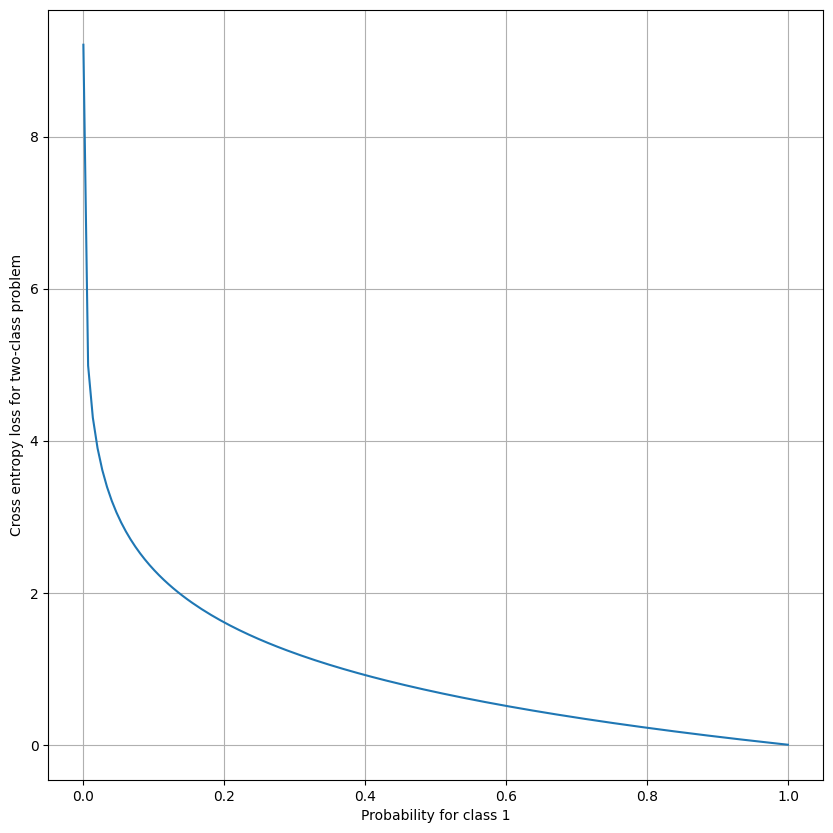

In [17]:
xs = np.linspace(0.0001,0.9999,150)
ys = 1-xs
loss = np.zeros_like(xs)
for i in range(len(xs)):
    loss[i]= -np.sum(np.array([1,0])*np.log(np.array([xs[i], ys[i]])))
    #이건 Cross-Entrophy 식인데 np.array[1,0]은 2class의 one-hot encoding이다. 뒤에꺼는 코드대로.
    
plt.figure(figsize=(10,10))
plt.plot(xs,loss)
plt.xlabel('Probability for class 1')
plt.ylabel('Cross entropy loss for two-class problem')
plt.grid()
plt.show()

We can see that as the probability for the target class approaches 0, the loss goes quickly up, providing a nice gradient!!

Finally, we note that the total cross-entropy loss for a set of $N$ datapoints is given as:

$$
L(\vec{t},\vec{p})=-\sum_{j=1}^N \sum_{i=1}^C \left( t_{ji} \cdot \log{(\vec{p}_{ji})} \right)
$$

Let's make a little function that demonstrates the CCE:

In [18]:
# function definition of CCE
def categorical_cross_entropy(t_list,p_list):
    # convert list to numpy variable
    t_list = np.float_(t_list)
    p_list = np.float_(p_list)
    # initialize the loss
    losses = []
    for t,p in zip(t_list,p_list):
        loss = -np.sum(t * np.log(p)) #여기도 cross-entrophy loss이다.
        losses.append(loss)
        print("t {}, p {},loss {}".format(t,p,loss))
    return np.sum(losses)

In [19]:
t_list = [[1,0,0],[0,1,0],[0,0,1],[1,0,0]]
p_list = [[0.91,0.04,0.05],[0.11,0.8,0.09],[0.3,0.1,0.6],[0.25,0.4,0.35]]
print('\nTotal loss for three class problem:',categorical_cross_entropy(t_list,p_list))

t [1. 0. 0.], p [0.91 0.04 0.05],loss 0.09431067947124129
t [0. 1. 0.], p [0.11 0.8  0.09],loss 0.2231435513142097
t [0. 0. 1.], p [0.3 0.1 0.6],loss 0.5108256237659907
t [1. 0. 0.], p [0.25 0.4  0.35],loss 1.3862943611198906

Total loss for three class problem: 2.214574215671332


### Derivative of cross entropy with softmax

In order to do backpropagation, we need the derivative of the cross entropy function.

$$
\frac{\partial L}{\partial z_i}=-\sum_{j=1}^N \frac{\partial}{\partial z_i}(t_j\log p_j) = -\sum_{j=1}^N t_j \frac{\partial}{\partial z_i}\log p_j = -\sum_{j=1}^N t_j \frac{1}{p_j}\frac{\partial p_j}{\partial z_i} 
$$

now, splitting the sum again:

$$
= -\frac{t_i}{p_i}\frac{\partial p_i}{\partial z_i}-\sum_{j\neq i} \frac{t_j}{p_j}\frac{\partial p_j}{\partial z_i} 
$$

where we now need the derivatives of the probabilities $p_k$ with respect to $z_i$. We calculated these above for the two cases $k=i$ and $k\neq i$, and can therefore substitute:

$$
= -\frac{t_i}{p_i}p_i(1-p_i)-\sum_{j\neq i} \frac{t_j}{p_j}(-p_i p_j) = -t_i +t_i p_i +\sum_{j\neq i} t_j p_i
$$

so the missing term $t_i p_i$ can be put back INTO the sum to yield:

$$
= -{t_i} + ∑_{j=1}^N{t_j}{p_i} = -{t_i} + {p_i}∑_{j=1}^N{t_j}
$$

$$
\rightarrow\frac{\partial L}{\partial z_i}= {p_i} - {t_i}
$$

which simply states that the derivative of the loss for a given example is the difference between the predicted probabilities and the true labels.

A LOT of number wrangling for a VERY simple result!!


#### Implementation

So, let's implement this for classification. For this, we will take the exact same code as above and create a one-hidden layer neural network. This time, however, we will add the softmax-cross-entropy part in order to support classification of the results.

We can actually re-use some of the functions from above for this, and most functions here only are changed very little to demonstrate the updates.

In [23]:
def softmax(X):
    exp_scores = np.exp(X)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 

def feed_forward_class(model, x):
    # get weights and biases
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # first layer
    z1 = x.dot(W1)+b1
    
    # activation function
    #a1 = logistic(z1)
    #a1 = tanh(z1)
    a1 = relu(z1)
    
    # second layer
    z2 = a1.dot(W2)+b2
    
    # softmax to get probabilities
    out = z2
    
    return z1, a1, z2, out, W1, W2

def calculate_loss_class(model,X,y,reg_lambda):
    num_examples = X.shape[0]
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # what are the current predictions
    z1, a1, z2, out, tmp1, tmp2 = feed_forward_class(model, X)
    
    # convert to probabilities via normalizing
    probs = out / np.sum(out, axis=1, keepdims=True)
    
    # convert to "logits"
    correct_logprobs = -np.log(probs[range(num_examples), y])
    
    # and sum to get cross entropy loss
    loss = np.sum(correct_logprobs)
    
    # add regulatization term to loss)
    loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    
    # return average per-item loss
    return 1./num_examples * loss

def backprop_class(X,y,model,z1,a1,z2,output,reg_lambda):
    
    # loss derivative
    delta3 = output
    
    # we have to think long and hard about this line!
    # this should be (output - y) as the outer loss derivative
    # from the cross-entropy + softmax result shown above
    #
    # why does this code work??
    delta3[range(X.shape[0]), y] -= 1
    # range(X.shape[0]): This generates a list of indices corresponding to the batch size, or number of examples in X.
    # delta3[range(X.shape[0]), y] -= 1: This line is subtracting 1 from the softmax probabilities specifically at the indices of the correct classes.
    # Essentially, for each example in the batch, it finds the probability assigned to the true class and subtracts 1.
    # 아까 우리가 cross-entrophy의 derivative는 p_i - t_i (predicted probability - true label)이었다는 걸 기억하면, 여기서 t_i 역할을 하는게 1이다.
    # By initializing delta3 as output and then subtracting 1 at the indices of the correct classes, delta3 is effectively set to p_i - 1 
    #where i is the correct class and remains p_i elsewhere. This matches the derivative of the cross-entropy loss, since the one-hot labels are 1 for the correct class and 0 for others.
    
   
    # multiply this by activation outputs of hidden layer
    dW2 = (a1.T).dot(delta3)
    # and over all neurons
    db2 = np.sum(delta3, axis=0, keepdims=True)
    
    # derivative of activation function
    #delta2 = delta3.dot(model['W2'].T) * logistic_derivative(a1) #if logistic
    #delta2 = delta3.dot(model['W2'].T) * tanh_derivative(a1) #if tanh
    delta2 = delta3.dot(model['W2'].T) * relu_derivative(a1) #if ReLU
    
    # multiply by input data
    dW1 = np.dot(X.T, delta2)
    # and sum over all neurons
    db1 = np.sum(delta2, axis=0)
    
    # add regularization terms on the two weights
    dW2 += reg_lambda * model['W2']
    dW1 += reg_lambda * model['W1']
    
    return dW1, dW2, db1, db2

# simple training loop - identical to above, only changing the function calls!
def train(model, X, y, num_passes=100000, reg_lambda = 0.1, learning_rate = 0.001):
    # whether to do stochastic gradient descent
    sgd = True
    
    # variable that checks whether we break iteration
    done = False
    
    # keeping track of losses
    previous_loss = float('inf')
    losses = []

    # iteration counter
    i = 0
    while done == False:
        if sgd:
            # choose a random set of points
            randinds = np.random.choice(np.arange(len(y)),30,False)
            # get predictions
            z1,a1,z2,output,w1,w2 = feed_forward_class(model, X[randinds,:])
            # feed this into backprop
            dW1, dW2, db1, db2 = backprop_class(X[randinds,:],y[randinds],model,z1,a1,z2,output,reg_lambda)
        else:
            # get predictions
            z1,a1,z2,output,w1,w2 = feed_forward_class(model, X)
            # feed this into backprop
            dW1, dW2, db1, db2 = backprop_class(X,y,model,z1,a1,z2,output,reg_lambda)
            
        # given the results of backprop, update both weights and biases
        model['W1'] -= learning_rate * dW1
        model['b1'] -= learning_rate * db1
        model['W2'] -= learning_rate * dW2
        model['b2'] -= learning_rate * db2
        
        # do some book-keeping every once in a while
        if i % 1000 == 0:
            loss = calculate_loss_class(model, X, y, reg_lambda)
            losses.append(loss)
            print("Loss after iteration {}: {}".format(i, loss))
            # very crude method to break optimization
            if np.abs((previous_loss-loss)/previous_loss) < 0.001:
                done = True
            previous_loss = loss
        i += 1
        if i>=num_passes:
            done = True
    return model, losses

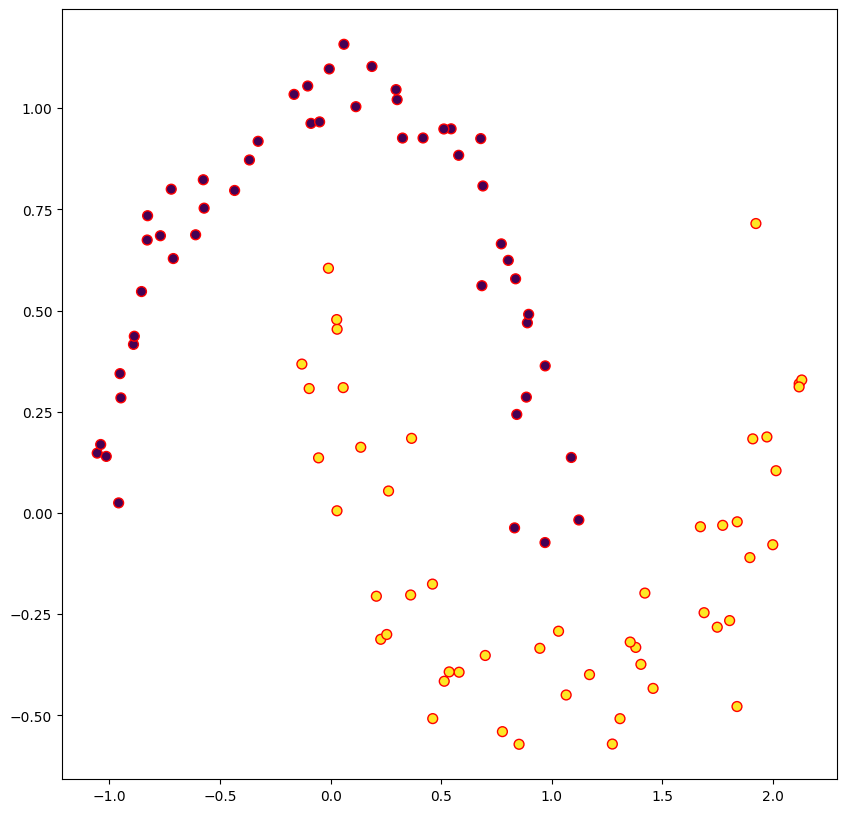

In [24]:
X, y = datasets.make_moons(100, noise=0.10)

#X, y = datasets.make_circles(n_samples=100, shuffle=True, noise=0.1, factor=0.4)



plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=50, edgecolor="r")
plt.show()

In [25]:
# training set size
num_examples = len(X) 
# input layer dimensionality
nn_input_dim = 2 
# output layer dimensionality - now TWO!
nn_output_dim = 2  
# learning rate for gradient descent
learning_rate = 0.001
# regularization strength
reg_lambda = 0.01 

# create the model
model = create_model(X,5,2)

# train it
model, losses = train(model,X, y, reg_lambda=reg_lambda, learning_rate=learning_rate)

# determine predictions of the trained model
output = feed_forward(model, X)

# and get the max activating output to determine class membership
preds = np.argmax(output[3], axis=1)

/var/folders/j2/bs26lyw51kq5vvb8gr82czpm0000gn/T/ipykernel_54209/820257990.py:35: RuntimeWarning: invalid value encountered in log
  correct_logprobs = -np.log(probs[range(num_examples), y])


Loss after iteration 0: nan
Loss after iteration 1000: 0.25057776271177384
Loss after iteration 2000: 0.21415823853213467
Loss after iteration 3000: 0.14589003409399515
Loss after iteration 4000: 0.09950051600675609
Loss after iteration 5000: 0.08720047620025762
Loss after iteration 6000: 0.07283585215717296
Loss after iteration 7000: 0.0747997195843738
Loss after iteration 8000: 0.06557306477523665
Loss after iteration 9000: 0.07538985385638655
Loss after iteration 10000: 0.08363963260552197
Loss after iteration 11000: 0.0630337296253202
Loss after iteration 12000: 0.06421256946836061
Loss after iteration 13000: 0.07359819685831168
Loss after iteration 14000: 0.07001631093973058
Loss after iteration 15000: 0.06996339534075227


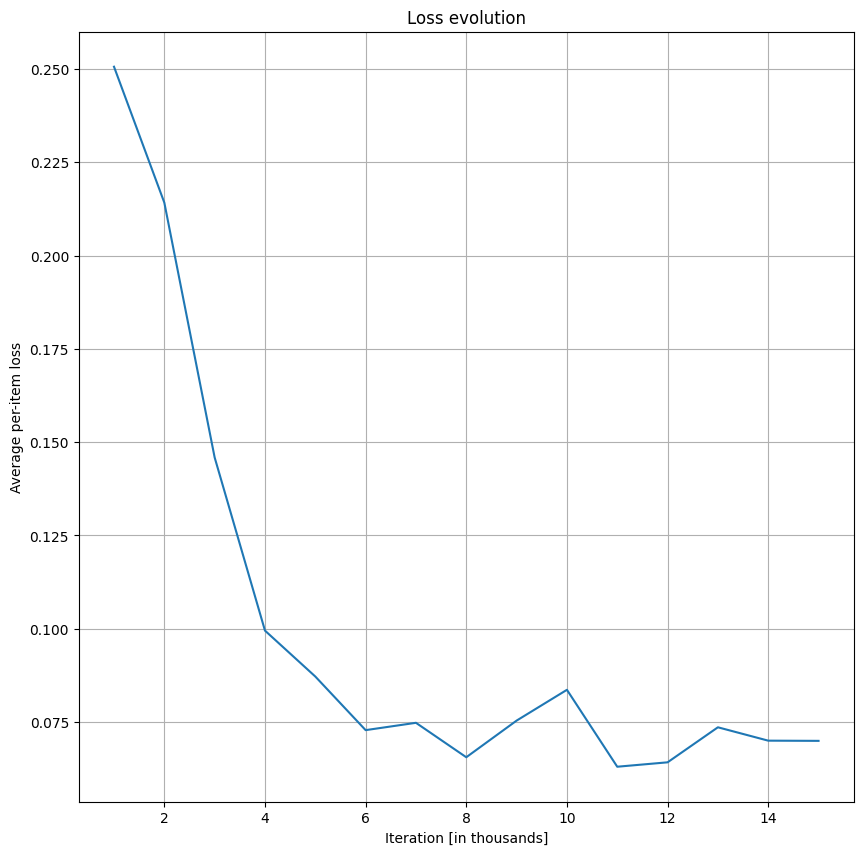

In [26]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

Next, we will plot the decision surface of the resulting classifier. 

For this, we will sample the full space and then use the matplotlib function "contourf" to plot the results.

/var/folders/j2/bs26lyw51kq5vvb8gr82czpm0000gn/T/ipykernel_54209/3575990122.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predarray[j,i] = np.argmax(tmp[3], axis=1)


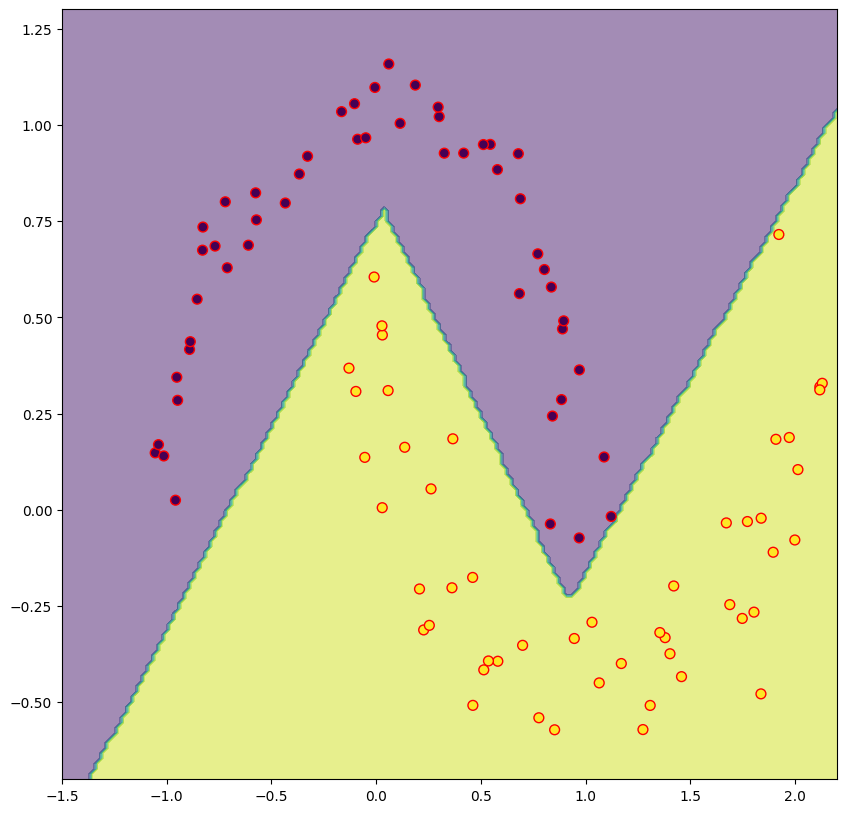

In [27]:
xs=np.linspace(-1.5,2.2,150)
ys=np.linspace(-0.7,1.3,150)
[xsm,ysm]=np.meshgrid(xs,ys)
predarray = np.zeros((len(xs),len(ys)))

for i,xt in enumerate(xs):
    for j,yt in enumerate(ys):
        tmp = feed_forward_class(model,np.array([xt,yt]))
        predarray[j,i] = np.argmax(tmp[3], axis=1)
        
plt.figure(figsize=(10,10))
plt.contourf(xs,ys,predarray,alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=50, edgecolor="r")
plt.show()

Remember that the output of the neural network is actually the probability that the point belongs to a certain class. We can actually plot that directly, by simply taking the "max" instead of the "argmax" above:

/var/folders/j2/bs26lyw51kq5vvb8gr82czpm0000gn/T/ipykernel_54209/3567515247.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predarray[len(ys)-1-j,i] = np.max(tmp[3],axis=1)


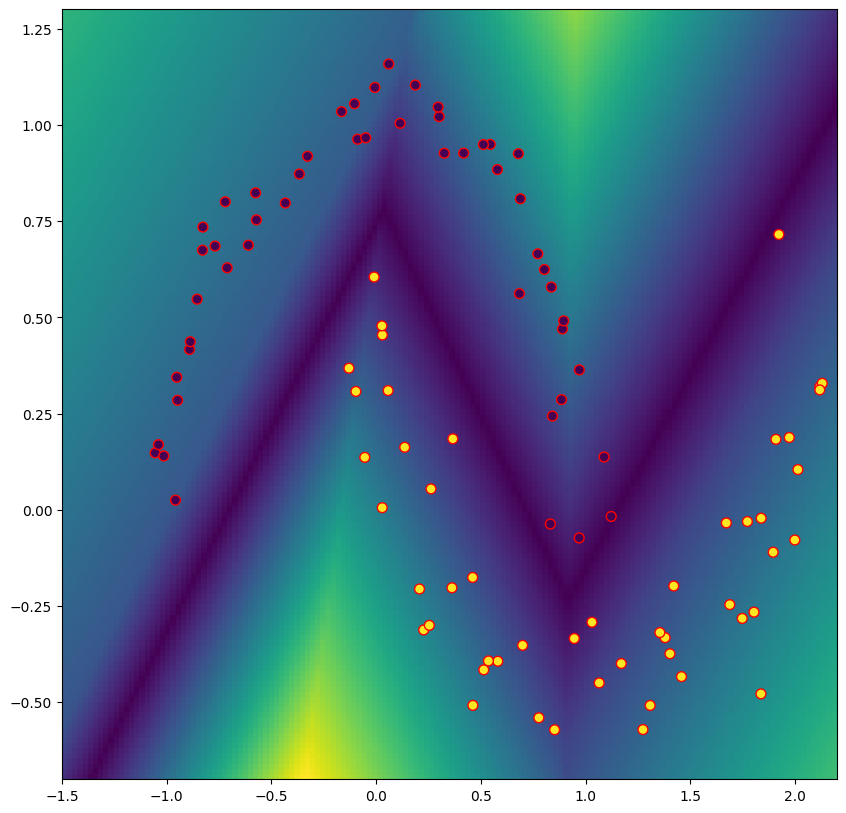

In [29]:
xs=np.linspace(-1.5,2.2,150)
ys=np.linspace(-0.7,1.3,150)
[xsm,ysm]=np.meshgrid(xs,ys)
predarray = np.zeros((len(xs),len(ys)))

for i,xt in enumerate(xs):
    for j,yt in enumerate(ys):
        tmp = feed_forward_class(model,np.array([xt,yt]))
        predarray[len(ys)-1-j,i] = np.max(tmp[3],axis=1)
        
plt.figure(figsize=(10,10))
plt.imshow(predarray,extent=(-1.5,2.2,-0.7,1.3),aspect='auto')
#plt.contourf(xs,ys,predarray,alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=50, edgecolor="r")
plt.show()

## Universality

It has been shown that a neural network with one hidden layer, containing sigmoid activation functions (so, non-linear!) can approximate any function!

Therefore, such networks are also called universal approximators.

Cybenko, G. Math. Control Signal Systems (1989) 2: 303:

"In this paper we demonstrate that finite linear combinations of compositions of a fixed, univariate function and a set of affine functionals can uniformly approximate any continuous function ofn real variables with support in the unit hypercube; only mild conditions are imposed on the univariate function. Our results settle an open question about representability in the class of single hidden layer neural networks. In particular, we show that arbitrary decision regions can be arbitrarily well approximated by continuous feedforward neural networks with only a single internal, hidden layer and any continuous sigmoidal nonlinearity. The paper discusses approximation properties of other possible types of nonlinearities that might be implemented by artificial neural networks."

The full paper can be found here:

https://web.njit.edu/~usman/courses/cs675_fall18/10.1.1.441.7873.pdf


**Breakout**

1. The visual proof that explicitly constructs a NN to approximate "any" function:

https://www.mathematik.uni-wuerzburg.de/fileadmin/10040900/2019/Seminar__Artificial_Neural_Network__24_9__.pdf


2. The excellent exposition of the proof of Cybenko by Daniela McNeela:

https://mcneela.github.io/machine_learning/2017/03/21/Universal-Approximation-Theorem.html

**Breakout**

Playing around with a neural network simulator

https://playground.tensorflow.org/



